<a href="https://colab.research.google.com/github/jcumbicosr/processamento-linguagem-natural/blob/main/Modelo_de_Linguagem_(Bengio_2003)_MLP_%2B_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IA024 - Modelagem de linguagem (Bengio et al., 2003)

(Bengio et al., 2003): Modelo capaz de prever a próxima palavra a partir de um contexto.

Dados: textos de Machado de Assis

Modelagem:

Entrada: quantidade pré-definida de palavras representa um contexto. Palavras são representadas através de inteiros resultantes de tokenização.

Rede Neural: palavras são transformadas em Embeddings, de onde deriva-se uma predição da próxima palavra com camadas lineares (Rede Neural MLP).

Saída: próxima palavra dado o contexto.

Avaliação: Perplexidade: uma medida da incerteza de um modelo de probabilidade em prever uma amostra.

Geração de Texto: Com este modelo, é possível gerar um texto através de janela deslizante de contexto.





## Imports

In [ ]:
import os
import re
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.nn import Embedding
from collections import Counter

## Dados


### Aquisição do dataset, preparação e análise

In [ ]:
!git clone https://github.com/ethelbeluzzi/projetomachado

Cloning into 'projetomachado'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 65 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 7.21 MiB | 2.94 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
# >>> Análise varia dependendo do formato que os dados são fornecidos <<<

DATA_PATH = os.path.join("projetomachado", "textonormalizado1000.txt")

# Abrir arquito textual e ler os dados originais
with open(DATA_PATH, "r") as data_file:
    data_text = data_file.read()

# Número total de caracteres no dataset
len(data_text)

18845445

In [ ]:
init = 100
data_text[init:init+500]

'achado de Assis\nI\nO fim da carta\nMas que pretendes fazer agora?\nMorrer.\nMorrer? Que idéia! Deixate disso, Estêvão. Não se morre por tão pouco...\nMorrese. Quem não padece estas dores não as pode avaliar. O golpe foi profundo, e o\nmeu coração é pusilânime; por mais aborrecível que pareça a idéia da morte, pior, muito pior do\nque ela, é a de viver. Ah! tu não sabes o que isto é?\nSei: um namoro gorado...\nLuís!\n... E se em cada caso de namoro gorado morresse um homem, tinha já diminuído muito o\ngêner'

In [ ]:
min_words = 6 # Minimum number of words per line
cleaned_lines = []
line_lens = []
total_words = 0
# Abrir arquito textual e ler os dados originais
with open(DATA_PATH, "r") as data_file:
    for line in data_file:
        # Limpar linhas, removendo \n, espaços antes e depois
        line = line.strip().lower()
        # Remove punctuation marks, except , and.
        line = re.sub(r'[^\w\s,.]', '', line)
        # Apagar linhas menor que min_words
        num_words = len(line.split())
        if num_words < min_words:
            continue
        # Contador de palavras
        total_words += num_words
        cleaned_lines.append(line)
        line_lens.append(len(line))
print(f'Total de linhas: {len(cleaned_lines)}')
print(f'Total de palavras: {total_words}')
print(f'Total de caracteres: {sum(line_lens)}')

Total de linhas: 233809
Total de palavras: 3086352
Total de caracteres: 17226274


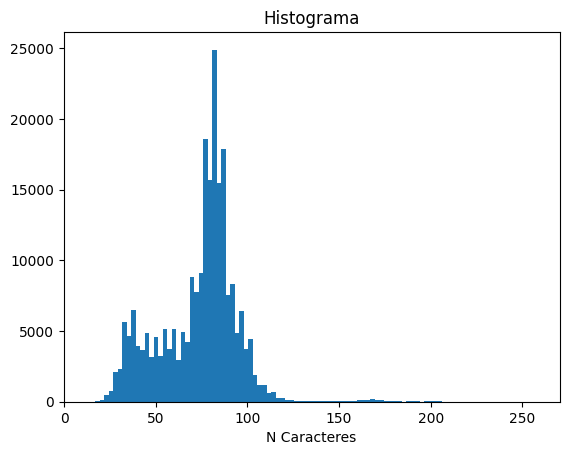

In [ ]:
plt.title("Histograma")
plt.hist(line_lens, bins=100)
plt.xlabel("N Caracteres")
plt.show()

In [ ]:
# calculate max length of lines
max_len = max(line_lens)
# get index of max length of lines
max_len_idx = np.argmax(line_lens)
print(f'Num lines: {len(cleaned_lines)}')
print(f'Max len: {max_len}')
print(f'Max line: {cleaned_lines[max_len_idx]}')

Num lines: 233809
Max len: 258
Max line: outras, os parlamentos de alguns países, etc. e a razão é esta. sendo os ingleses, em geral, muito ocupados, pouco tempo lhesresta para ver as coisas alheias. daí a necessidade de limitar os dias de trabalho parlamentar dos ditos países, a fim de que aqueles


In [ ]:
cleaned_lines[160:180]

['também,  apercebidas de flores, de versos, de coroas, e até de estalinhos. uma noite a ação',
 'travouse entre o campo lagruísta e o campo chartonista, com tal violência, que parecia uma',
 'página da ilíada. desta vez, a vênus da situação saiu ferida do combate um estalo rebentara no',
 'rosto da charton. o furor, o delírio, a confusão foram indescritíveis o aplauso e a pateada deram',
 'se as mãos,  e os pés. a peleja passou aos jornais. vergonha terna dizia um aos cavalheiros',
 'que cuspiram na face de uma dama  se for mister replicava outro daremos os nomes dos',
 'aristarcos que no saguão do teatro juraram desfeitear mlle. lagrua.  patuléia desenfreada',
 'os que escaparam daquelas guerras de alecrim e manjerona hão de sentir hoje, após',
 'dezoito anos, que despenderam excessivo entusiasmo em coisas que pediam repouso',
 'estêvão é uma das relíquias daquela tróia, e foi um dos mais fervorosos lagruístas, antes',
 'e depois do grau. a causa principal das suas preferências, era 

In [ ]:
# Contar número de palavras ÚNICAS
def split_text(text):
    return re.findall(r'\w+|[.,]', text)

def count_words(texts):
    # Counter: collection especifica do Python para contar ocorrências de um objeto
    word_counts = Counter()
    for text in texts:
        # Separar em palavras, incluso caracteres de pontuação
        words = split_text(text)
        word_counts.update(words)
        #### Separado com regex, \w+: sequências alfanuméricas
    return word_counts

word_counts = count_words(cleaned_lines)

len(word_counts)

72140

In [ ]:
word_counts.most_common(10)

[(',', 293300),
 ('.', 193625),
 ('a', 126620),
 ('que', 116215),
 ('de', 104138),
 ('e', 97904),
 ('o', 94950),
 ('não', 59365),
 ('um', 39440),
 ('do', 38250)]

### Tokenização

In [ ]:
# Criação de vocabulário, utilizando somente split de treino como referência
VOCAB_SIZE = 2000
most_frequent_words = [word for word, count in word_counts.most_common(VOCAB_SIZE)]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)}
vocab['<unk>'] = 0

In [ ]:
# Função de tokenização
def encode_sentence(sentence, vocab):
    # Usa regex para separar palavras (sequências alfa numéricas)
    return [vocab.get(word, 0) for word in split_text(sentence)]

random_sentence = random.choice(cleaned_lines)
encoded_sentence = encode_sentence(random_sentence, vocab)
print(f"{random_sentence}\n{encoded_sentence}")

religiosa. ao pé do altar viase a si mesmo, magno sacerdote, com uma túnica de linho e
[0, 2, 22, 184, 10, 0, 0, 3, 111, 61, 1, 0, 0, 1, 14, 15, 0, 5, 0, 6]


## Modelagem baseada em (Bengio et al. 2003)


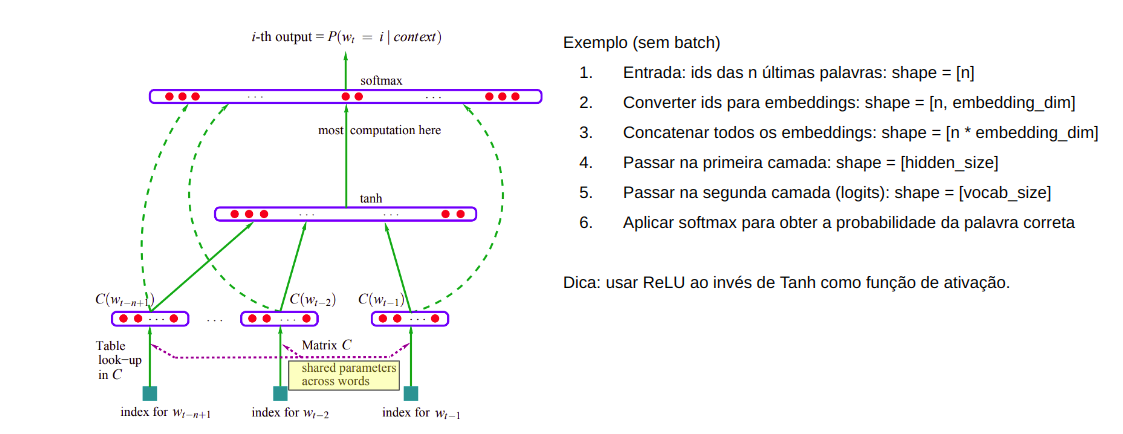

### Embedding
Como funciona o nn.Embedding? Vamos olhar o código fonte!

In [ ]:
embedding = Embedding(10, 2)

In [ ]:
embedding.weight.shape

torch.Size([10, 2])

In [ ]:
# Selecionar embedding dos tokens 0 a 9. A indexação é feita através de inteiros em um Tensor do PyTorch.
embedding(torch.tensor(0))

tensor([ 1.6562, -1.7330], grad_fn=<EmbeddingBackward0>)

In [ ]:
# Selecionar embeddings dos tokens 0 e 2
e = embedding(torch.tensor([0, 2]))

e.shape, e
# Como fazer com batch?

(torch.Size([2, 2]),
 tensor([[ 1.6562, -1.7330],
         [ 0.3599,  0.4126]], grad_fn=<EmbeddingBackward0>))

In [ ]:
# Simulando um batch de duas frases de 2 tokens
####
e = embedding(torch.tensor([[0, 2], [1, 3]]))

# Como concatenar para passarmos de [B, W, D] para [B, W*D]?
####

In [ ]:
e.shape
e.view(e.shape[0], -1).shape

torch.Size([2, 4])

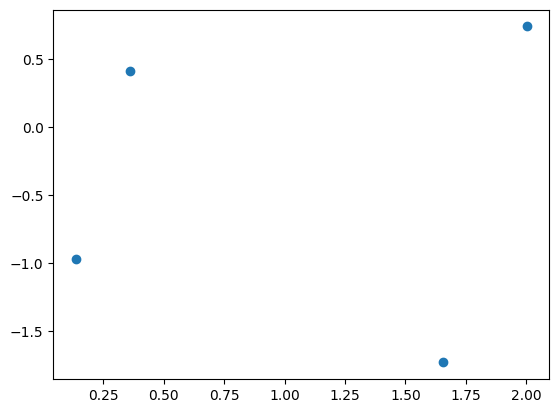

In [ ]:
# Um embedding de 2 dimensões pode ser representado em gráfico.
# Note que poderíamos calcular uma distância entre embeddings! Essa distância faz parte do poder representacional de embeddings.
e = embedding(torch.tensor([0, 1, 2, 3])).detach().numpy()
plt.scatter(e[:,0], e[:,1])
plt.show()

# Enunciado do Exercício: Modelo de Linguagem (Bengio 2003) - MLP + Embeddings

Neste exercício iremos treinar uma rede neural similar a do Bengio 2003 para prever a próxima palavra de um texto, data as palavras anteriores como entrada. Esta tarefa é chamada de "Modelagem da Linguagem".

Portanto, você deve implementar o modelo de linguagem inspirado no artigo do Bengio, para prever a próxima palavra usando rede com embeddings e duas camadas.
Sugestão de alguns parâmetros:
* context_size = 5
* max_vocab_size = 2000
* embedding_dim = 64
* usar pontuação no vocabulário
* descartar qualquer contexto ou target que não esteja no vocabulário
* É esperado conseguir uma perplexidade da ordem de **150**.
* Procurem fazer asserts para garantir que partes do seu programa estão testadas

Este enunciado não é fixo, podem mudar qualquer um dos parâmetros acima, mas procurem conseguir a perplexidade esperada ou menor.

Gerem alguns frases usando um contexto inicial e depois deslocando o contexto e prevendo a próxima palavra gerando frases compridas para ver se está gerando texto plausível.

Algumas dicas:
- Inclua caracteres de pontuação (ex: `.` e `,`) no vocabulário.
- Deixe tudo como caixa baixa (lower-case).
- A escolha do tamanho do vocabulario é importante: ser for muito grande, fica difícil para o modelo aprender boas representações. Se for muito pequeno, o modelo apenas conseguirá gerar textos simples.
- Remova qualquer exemplo de treino/validação/teste que tenha pelo menos um token desconhecido (ou na entrada ou na saída).
- Durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- Não deixe para fazer esse exercício na véspera. Ele é trabalhoso.

Procure por `TODO` para entender onde você precisa inserir o seu código.

## Classe do dataset

A Classe Dataset é um dos aspectos mais trabalhosos do desenvolvimento de modelos com Deep Learning. Crie uma classe Dataset do PyTorch para este problema. Lembre-se de documentar e testar utilizando-se de asserts. Explique sua lógica de forma concisa com comentários.  

In [ ]:
from torch.utils.data import Dataset, DataLoader

context_size = 5 # 5 palavras de entrada. O target é a próxima palavra

"""TODO: Preparar o dataset"""
class MachadoDataset(Dataset):
    def __init__(self, text, vocab, context_size=5):
        self.vocab = vocab
        self.context_size = context_size

        self.source = []
        self.target = []
        for line in text:
            tokens = encode_sentence(line, vocab)
            # Sliding windows
            for i in range(len(tokens)-context_size-1):
                data = tokens[i:i+context_size+1]
                # Delete if data contain <ukn> token
                if 0 in data:
                    continue
                self.source.append(data[:-1])
                self.target.append(data[-1])

    def __len__(self):
        return len(self.source)

    def __getitem__(self, idx):
        return torch.tensor(self.source[idx]), torch.tensor(self.target[idx])

class MachadoDataset_v2(Dataset):
    def __init__(self, text, vocab, context_size=5):
        self.vocab = vocab
        self.context_size = context_size

        mono_text = []
        self.source = []
        self.target = []
        for line in text:
            tokens = encode_sentence(line, vocab)
            mono_text.extend(tokens)

        # Sliding windows
        for i in range(len(mono_text)-context_size-1):
            data = mono_text[i:i+context_size+1]
            # Delete if data contain <ukn> token
            if 0 in data:
                continue
            self.source.append(data[:-1])
            self.target.append(data[-1])

    def __len__(self):
        return len(self.source)

    def __getitem__(self, idx):
        return torch.tensor(self.source[idx]), torch.tensor(self.target[idx])

#my_dataset = MachadoDataset(cleaned_lines, vocab, context_size)
my_dataset = MachadoDataset_v2(cleaned_lines, vocab, context_size)
sample = my_dataset[0]
print(f'Length of Dataset: {len(my_dataset)}')
print('==> Sample <==')
print(f'Source: {sample[0]}')
print(f'Target: {sample[1]}')

Length of Dataset: 1044813
==> Sample <==
Source: tensor([497,   1, 796,   2,   8])
Target: 16


In [ ]:
"""TODO: divida o dataset em validação/treino com um proporção de 20/80 %. OBS, use random_state=18"""
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(my_dataset, test_size=0.2, random_state=18)

#from torch.utils.data import random_split
#train_size = int(0.8 * len(my_dataset))
#val_size = len(my_dataset) - train_size
#train_data, val_data = random_split(my_dataset, [train_size, val_size])

In [ ]:
# inverse vocabulary
inverse_vocab = {v: k for k, v in vocab.items()}

def tokens_to_str( tokens):
    return ' '.join(inverse_vocab[token] for token in tokens)

In [ ]:
start = 2000
for i in range(start, start + 50):
    sample = train_data[i]
    #print(f'Input: {sample[0].tolist()} | Output: {sample[1].tolist()}')
    txt_in = tokens_to_str(sample[0].tolist())
    txt_out = tokens_to_str([sample[1].tolist()])
    print(f'Input: {txt_in} | Output: {txt_out}')


Input: o jantar , camargo deu | Output: conta
Input: e a razão naturalmente é | Output: que
Input: por si a beleza e | Output: a
Input: aqui o mais útil remédio | Output: às
Input: mais íntima , éramos três | Output: pessoas
Input: e profundo . a pessoa | Output: que
Input: com a recusa da moça | Output: mas
Input: família , para os amigos | Output: e
Input: você não vê como seus | Output: pais
Input: ausência . . . não | Output: ,
Input: veio , respondeu a boa | Output: senhora
Input: . ou porque eram dele | Output: ,
Input: as ia deixando pela boa | Output: terra
Input: igualmente me lembra , apesar | Output: de
Input: antes o sonho da velhice | Output: ,
Input: , nem era preciso para | Output: darlhe
Input: sabendo que não núcleo de | Output: pesquisas
Input: hora para ir ao largo | Output: de
Input: a vasconcelos que estava na | Output: sala
Input: . . . se o | Output: imperador
Input: saindo ele , a moça | Output: deixou
Input: que os teve . . | Output: .
Input: da sala , falando 

### Inicialização de DataLoaders
Os DataLoaders do PyTorch cuidam da criação do batch de forma eficiente e com possibildade de paralelismo. Sempre visualize exemplos do DataLoader para verificar que o batch está sendo criado da forma esperada. Grande parte dos erros ocorrem na definição do Dataset e do Dataloader.

In [ ]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

sample = next(iter(train_loader))
print(f'Shape of source: {sample[0].shape}')
print(f'Shape of target: {sample[1].shape}')

Shape of source: torch.Size([128, 5])
Shape of target: torch.Size([128])


## Model
Crie uma classe de Modelo herdando de torch.nn.Module. Um nn.Module deve definir o que acontece no "forward", ou seja, o que é feito com o dado (geralmente o batch) fornecido para a rede.

Procure ler sobre a documentação do nn.Module e entender porque é necessário que a classe do modelo precisa herdar de nn.Module.

In [ ]:
import torch.nn as nn

class LanguageModel(torch.nn.Module):
    """TODO: implementar o modelo de linguagem"""
    def __init__(self, vocab_size, embed_size, context_size, hidden_size, dropout=0.3):
        super(LanguageModel, self).__init__()

        self.embed_size = embed_size
        self.context_size = context_size

        # Lookup table for word embeddings
        self.embeddings = nn.Embedding(vocab_size, embed_size)

        # Hidden layer
        self.hidden_1 = nn.Linear(context_size * embed_size, hidden_size)
        #self.hidden_2 = nn.Linear(hidden_size, hidden_size)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Output layer
        self.output = nn.Linear(hidden_size, vocab_size)

    def forward(self, context_words):
        # Get embeddings for the context words
        embeds = self.embeddings(context_words)  # (batch_size, context_size, embed_size)

        # Flatten the embeddings into a single vector
        embeds = embeds.view(embeds.size(0), -1)  # (batch_size, context_size * embed_size)

        # Pass through the hidden layer
        hidden_out = F.relu(self.hidden_1(embeds))  # (batch_size, hidden_size)
        #hidden_out = F.relu(self.hidden_2(hidden_out))  # (batch_size, hidden_size)

        # Pass through the output layer
        outputs = self.output(self.dropout(hidden_out))  # (batch_size, vocab_size)

        # Apply softmax to get the probability distribution over the vocabulary
        # Essa linha foi comentada baseado no codigo do José de Arimatéa Passos Lopes Jr
        #outputs = F.softmax(outputs, dim=-1)

        return outputs


# Define hyperparameters
vocab_size = len(vocab)+1  # Size of the vocabulary
embed_size = 128            # Dimension of word embeddings
#context_size = 5           # Number of context words
hidden_size = 512          # Number of neurons in the hidden layer

# Model instantiation
model = LanguageModel(vocab_size, embed_size, context_size, hidden_size)

print(model)
# Count number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

LanguageModel(
  (embeddings): Embedding(2002, 128)
  (hidden_1): Linear(in_features=640, out_features=512, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=512, out_features=2002, bias=True)
)
Total number of parameters: 1611474


In [ ]:
for p in model.parameters():
    print(p.shape)

torch.Size([2002, 128])
torch.Size([512, 640])
torch.Size([512])
torch.Size([2002, 512])
torch.Size([2002])


### Teste do modelo
É essencial testar o forward do modelo antes de tentar treinar, muitos erros podem ser pegos neste teste rápido. Use uma amostra do DataLoader para testar se as saídas são o esperado.

In [ ]:
sample = next(iter(train_loader))
input = sample[0]
target = sample[1]

outputs = model(input)
outputs.shape

torch.Size([128, 2002])

In [ ]:
outputs.argmax(dim=-1)

tensor([1901, 1302, 1203, 1112, 1393,   37,  225,  875,   12, 1590, 1354,  379,
        1901,  289, 1563, 1899, 1691,  628, 1836,  477,   67,  340,  936, 1066,
         913, 1709,  169, 1974,  406, 1944, 1579,  342,   12,  857, 1729,  438,
         591, 1647, 1352,  431, 1902,  859, 1751,  364,  364, 1927,  469, 1580,
        1235, 1438,  354,  422,  941, 1968,  692,  137, 1868,  354, 1563,  701,
         831,  695, 1865, 1806,  275,  593,  307, 1146, 1563, 1566, 1654,  137,
         496, 1333, 1637,  775, 1897, 1089, 1914,   60, 1563,  134,  762, 1897,
        1425, 1562,  118, 1536,  236,  298,  862, 1840,  528,  878,  672, 1959,
        1207,   49, 1949, 1400, 1078,  287,  873,  438,  406, 1720, 1637, 1635,
        1281, 1354,  980, 1668,  754, 1417,  664, 1583, 1475, 1400,  209, 1654,
         496, 1015,  915,  682,  504, 1108, 1365, 1365])

In [ ]:
target.shape

torch.Size([128])

## Training
Finalmente, implemente o loop de treino, onde os dados são fornecidos ao modelo, e os otimizadores otimizam os pesos do modelo em uma tentativa de minimizar a função de perda.

Ele envolve o uso de instâncias de otimizadores e funções de perda. Procure organizar o loop de treino em múltiplas funções em vez de um código monolítico, para facilitar a re-utilização de código no futuro.

Procure informar o resultado da loss tanto em treino quanto em validação. Opcional: plote um gráfico da loss em cada época de treino e validação.

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import time

epochs = 15
lr = 5e-4; """TODO, experimente!"""
criterion = nn.CrossEntropyLoss(); """TODO CrossEntropy"""

# Model instantiatio
model = LanguageModel(vocab_size, embed_size, context_size, hidden_size)
# Move the model to the appropriate device (GPU or CPU)
model.to(device)

# Initialize model parameters
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)


optimizer = torch.optim.Adam(model.parameters(), lr=lr); """TODO: AdamW ou outro, experimente!"""

"""TODO: Implemente o loop de treinamento. Em cada época, calcule e imprima a loss no dataset de validação. Opcional: Plote um gráfico da loss de validação e treino"""

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    test_acc = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        logits = model(inputs)
        loss = criterion(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = logits.argmax(dim=1)
        accuracy = (preds == targets).float().mean()
        test_acc += accuracy.item()

    return total_loss / len(train_loader), (test_acc / len(train_loader)) * 100

def valid_epoch(model, valid_loader, criterion, device):
    ## evaluation
    val_acc = 0
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            logits = model(inputs)

            # Calculate loss
            loss = criterion(logits, targets)
            val_loss += loss.item()

            # Calculate acc
            preds = logits.argmax(dim=1)
            accuracy = (preds == targets).float().mean()
            val_acc += accuracy.item()

    return val_loss / len(val_loader), (val_acc / len(val_loader)) * 100

# Save history to dictionnary
history = {
    'train_loss': [],
    'eval_loss': [],
    'train_acc': [],
    'eval_acc': []
}

# Initial evaluation
val_loss, val_acc = valid_epoch(model, val_loader, criterion, device)
perplexity = torch.exp(torch.tensor(val_loss))
print(f'[Initial] Test loss:{val_loss:.4f}, Test acc:{val_acc:.2f}%, Perplexity:{perplexity:.2f}')

# Training loop
for epoch in range(epochs):
    start_time_epoch = time.time()  # Start time of the epoch

    # train model
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # evaluate model
    val_loss, val_acc = valid_epoch(model, val_loader, criterion, device)

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time_epoch  # Duration of epoch

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['eval_loss'].append(val_loss)
    history['eval_acc'].append(val_acc)

    perplexity = torch.exp(torch.tensor(val_loss))
    print(f'Epoch [{epoch+1}/{epochs}], Train loss:{train_loss:.4f}, Train acc:{train_acc:.2f}%, '
          f'Test loss:{val_loss:.4f}, Test acc: {val_acc:.2f}%, '
          f'Perplexity:{perplexity:.2f}, Elapsed Time: {epoch_duration:.2f} sec')


[Initial] Test loss:7.6099, Test acc:0.02%, Perplexity:2018.16
Epoch [1/15], Train loss:4.7547, Train acc:15.95%, Test loss:4.3493, Test acc: 18.70%, Perplexity:77.43, Elapsed Time: 16.86 sec
Epoch [2/15], Train loss:4.2241, Train acc:19.73%, Test loss:4.1217, Test acc: 20.68%, Perplexity:61.67, Elapsed Time: 16.73 sec
Epoch [3/15], Train loss:3.9976, Train acc:21.51%, Test loss:3.9863, Test acc: 21.98%, Perplexity:53.85, Elapsed Time: 17.51 sec
Epoch [4/15], Train loss:3.8174, Train acc:23.13%, Test loss:3.8855, Test acc: 23.06%, Perplexity:48.69, Elapsed Time: 16.74 sec
Epoch [5/15], Train loss:3.6587, Train acc:24.78%, Test loss:3.8019, Test acc: 24.10%, Perplexity:44.79, Elapsed Time: 17.31 sec
Epoch [6/15], Train loss:3.5181, Train acc:26.48%, Test loss:3.7339, Test acc: 25.28%, Perplexity:41.84, Elapsed Time: 17.15 sec
Epoch [7/15], Train loss:3.3947, Train acc:28.14%, Test loss:3.6830, Test acc: 26.13%, Perplexity:39.76, Elapsed Time: 16.62 sec
Epoch [8/15], Train loss:3.2878, T

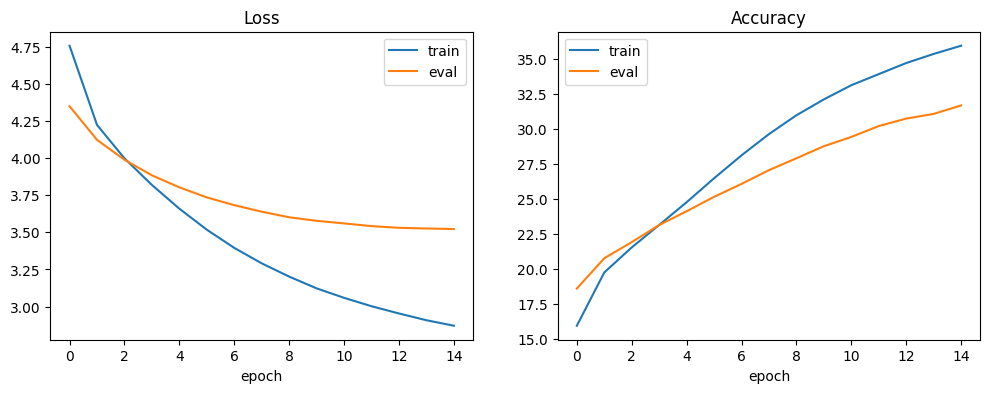

In [ ]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='train')
plt.plot(history['eval_loss'], label='eval')
plt.legend()
plt.title('Loss')
plt.xlabel('epoch')
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='train')
plt.plot(history['eval_acc'], label='eval')
plt.legend()
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

## Avaliação
Calcule a perplexidade utilizando todo o dataset de validação. Pesquise o que é a perplexidade e como implementá-la.

In [ ]:
""" TODO: calcule a perplexidade final no dataset de validação """

def calculate_perplexity(model, data_loader, criterion, device):
    """
    Calculates the perplexity of a language model on a given dataset.

    Args:
        model: The language model to evaluate.
        data_loader: DataLoader for the evaluation dataset.
        criterion: Loss function (usually cross-entropy).
        device: Device to run the computation on (e.g., 'cuda' or 'cpu').

    Returns:
        The perplexity score.
    """

    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_words = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            logits = model(inputs)  # Get model predictions
            #loss = criterion(logits.view(-1, logits.size(-1)), targets.view(-1))  # Calculate loss
            loss = criterion(logits, targets)  # Calculate loss

            total_loss += loss.item() * targets.size(0)  # Accumulate loss
            total_words += targets.numel()  # Count total words

    avg_loss = total_loss / total_words  # Average loss per word
    perplexity = torch.exp(torch.tensor(avg_loss))  # Calculate perplexity

    return perplexity.item()

# Calculate perplexity
perplexity = calculate_perplexity(model, val_loader, criterion, device)
print(f'Perplexity: {perplexity}')

Perplexity: 1836.656005859375


## Exemplo de uso
Como um modelo de linguagem pode gerar um texto? Pense como uma "janela deslizante", onde o contexto é sempre as palavras anteriores. Produza textos para avaliar o modelo de forma qualitativa.

In [ ]:
"""TODO: implemente a função para gerar texto até atingir o max_length"""

class NextWord(nn.Module):
    def __init__(self, language_model, vocab, context_size):
        super(NextWord, self).__init__()
        self.model = language_model
        self.context_size = context_size
        self.vocab = vocab
        self.inverse_vocab = {i: word for word, i in vocab.items()}

    def str_to_tokens(self, sentence):
        return [self.vocab.get(word, 0) for word in split_text(sentence)]

    def tokens_to_str(self, tokens):
        return ' '.join(self.inverse_vocab[token] for token in tokens)

    def __call__(self, text, max_length):
        input = torch.tensor(self.str_to_tokens(text)).to(device)
        self.model.eval()
        print('Output: ', end='')
        for step in range(len(input), max_length):
             # Calculate the start index for slicing; ensure it's not negative
             start_idx = max(0, step - self.context_size)
             # Slice the input tensor to get the context
             context = input[start_idx:step].unsqueeze(0)

             logits = self.model(context)
             output = logits.argmax(dim=1)

             #print(f"Context: {context.tolist()} | Output: {output.tolist()}")
             print(output.tolist(), end=' ')

             input = torch.cat((input, output))

        return self.tokens_to_str(input.tolist())



next_word = NextWord(model, vocab, context_size)

print(f'\n===========> Test <===========')
text = "bom dia, tudo bem"
max_length= 100
next_word(text, max_length)


===========> Test <===========
Output: [1] [3] [77] [13] [63] [211] [1] [6] [3] [331] [5] [1609] [2] [21] [9] [78] [4] [7] [203] [13] [4] [8] [16] [99] [89] [4] [1250] [119] [1] [6] [23] [4] [8] [204] [7] [4] [16] [99] [1050] [9] [490] [1] [4] [3] [104] [8] [31] [42] [54] [2] [8] [1789] [4] [7] [271] [390] [11] [1127] [2] [8] [16] [99] [89] [4] [1250] [119] [1] [6] [23] [4] [8] [204] [7] [4] [16] [99] [1050] [9] [490] [1] [4] [3] [104] [8] [31] [42] [54] [2] [8] [1789] [4] [7] [271] [390] [11] 

'bom dia , tudo bem , a vida é tão boa , e a resposta de raquel . era um homem que o filho é que não se pode dizer que itaguaí fosse , e por que não seria o que se pode chamar um irmão , que a moça não lhe disse nada . não tardou que o próprio autor da comédia . não se pode dizer que itaguaí fosse , e por que não seria o que se pode chamar um irmão , que a moça não lhe disse nada . não tardou que o próprio autor da'

In [ ]:
print(f'===========> Test <===========')
text = "que é uma boa literatura"
max_length= 150
next_word(text, max_length)

===========> Test <===========
Output: [1] [4] [8] [13] [1889] [36] [7] [4] [31] [1636] [1] [6] [1] [16] [8] [119] [3] [118] [101] [2] [3] [700] [1] [8] [13] [239] [89] [4] [3] [56] [428] [208] [13] [4] [8] [273] [7] [4] [13] [4] [7] [390] [982] [130] [1] [6] [8] [34] [707] [4] [28] [8] [84] [495] [5] [48] [2] [7] [4] [13] [4] [8] [13] [3] [56] [1183] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] 

'que é uma boa literatura , que não é prosa nem o que lhe dissera , e , se não fosse a mesma coisa . a sociedade , não é preciso dizer que a minha última palavra é que não sabe o que é que o autor dessa carta , e não foi difícil que ele não podia deixar de ser . o que é que não é a minha vocação é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas'

In [ ]:
print(f'===========> Test <===========')
text = "mas o que é verdade"
max_length= 130
next_word(text, max_length)

===========> Test <===========
Output: [13] [4] [7] [52] [114] [273] [4] [1801] [14] [105] [320] [2] [8] [32] [198] [4] [8] [16] [99] [89] [4] [1250] [119] [1] [6] [23] [4] [8] [204] [7] [4] [16] [99] [1050] [9] [490] [1] [4] [3] [104] [8] [31] [42] [54] [2] [8] [1789] [4] [7] [271] [390] [11] [1127] [2] [8] [16] [99] [89] [4] [1250] [119] [1] [6] [23] [4] [8] [204] [7] [4] [16] [99] [1050] [9] [490] [1] [4] [3] [104] [8] [31] [42] [54] [2] [8] [1789] [4] [7] [271] [390] [11] [1127] [2] [8] [16] [99] [89] [4] [1250] [119] [1] [6] [23] [4] [8] [204] [7] [4] [16] [99] [1050] [9] [490] [1] [4] [3] [104] [8] [31] [42] [54] [2] [8] [1789] [4] [7] 

'mas o que é verdade é que o meu coração sabe que batia com grande força . não me parece que não se pode dizer que itaguaí fosse , e por que não seria o que se pode chamar um irmão , que a moça não lhe disse nada . não tardou que o próprio autor da comédia . não se pode dizer que itaguaí fosse , e por que não seria o que se pode chamar um irmão , que a moça não lhe disse nada . não tardou que o próprio autor da comédia . não se pode dizer que itaguaí fosse , e por que não seria o que se pode chamar um irmão , que a moça não lhe disse nada . não tardou que o'

In [ ]:
print(f'===========> Test <===========')
text = "o chapéu grande precisa de"
max_length= 120
next_word(text, max_length)

===========> Test <===========
Output: [9] [1352] [2] [7] [4] [13] [4] [8] [13] [3] [56] [1183] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] 

'o chapéu grande precisa de um escravo . o que é que não é a minha vocação é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas'

In [ ]:

print(f'===========> Test <===========')
text = "excelente dia para ficar em"
max_length= 130
next_word(text, max_length)

===========> Test <===========
Output: [41] [1] [6] [34] [3] [164] [65] [4] [7] [299] [14] [3] [118] [401] [2] [3] [118] [1] [243] [1] [4] [3] [532] [242] [102] [7] [113] [5] [488] [2] [8] [31] [1585] [4] [7] [100] [8] [31] [464] [3] [320] [1782] [2] [1097] [1256] [2] [1097] [8] [121] [874] [1] [19] [36] [23] [97] [1] [36] [3] [189] [36] [7] [4] [13] [4] [32] [42] [1] [6] [29] [8] [233] [687] [1] [19] [7] [1387] [10] [731] [724] [1] [6] [8] [34] [3] [118] [101] [2] [2] [2] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] [13] [116] [2] [19] [8] [13] [4] [8] 

'excelente dia para ficar em casa , e foi a primeira vez que o fazia com a mesma graça . a mesma , porém , que a prima queria ver o pai de estela . não lhe faltava que o amor não lhe dá a força necessária . quisera querer . quisera não ter sentido , mas nem por isso , nem a senhora nem o que é que me disse , e eu não tenho dúvida , mas o encontro do quincas borba , e não foi a mesma coisa . . . não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não é verdade . mas não é que não'